In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datacompy
import os
import numpy as np
from scipy.io import arff

# narzedzia
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_val_predict,
    learning_curve,
    RepeatedStratifiedKFold,
    GridSearchCV
)
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.preprocessing import LabelEncoder

# modele + Smote
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from ctgan import CTGAN

In [23]:
# code
df = pd.read_csv("D:/ml/xgboost-main/data/spambase/spambase.csv")
df = df.drop_duplicates()
print(df.head())
print(df.dtypes)

#add new column = "source" with value = "oryginal" and save
path = "D:\\ml\\xgboost-main\\data\\spambase\\oryginal_dataset.csv"
df = df.copy()
df['source'] = 'original'
df.to_csv(path)

   word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
0            0.00               0.64           0.64           0.0   
1            0.21               0.28           0.50           0.0   
2            0.06               0.00           0.71           0.0   
3            0.00               0.00           0.00           0.0   
4            0.00               0.00           0.00           0.0   

   word_freq_our  word_freq_over  word_freq_remove  word_freq_internet  \
0           0.32            0.00              0.00                0.00   
1           0.14            0.28              0.21                0.07   
2           1.23            0.19              0.19                0.12   
3           0.63            0.00              0.31                0.63   
4           0.63            0.00              0.31                0.63   

   word_freq_order  word_freq_mail  ...  char_freq_;  char_freq_(  \
0             0.00            0.00  ...         0.00        0.000   
1 

### Training & Test Data

In [24]:
df2 = df.drop(columns="source")
y = df2["spam"]
X = df2.drop(columns=["spam"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape)
print(X_test.shape)

#concat X_train & y_train -> used to save files
df_original = pd.concat([X_train, y_train], axis=1)          
df_original['source'] = 'original'  

#save test samples
y_test.to_csv("D:\\ml\\xgboost-main\\data\\spambase\\test_data\\y_test.csv")
X_test.to_csv("D:\\ml\\xgboost-main\\data\\spambase\\test_data\\X_test.csv")

(3368, 57)
(842, 57)


### Oversampling - SMOTE

Przed Counter({0: 2010, 1: 1358})
Po Counter({0: 2010, 1: 2010})
Plik istnieje pod ścieżką: D:\ml\xgboost-main\data\spambase\smote_data.csv


<Axes: xlabel='spam'>

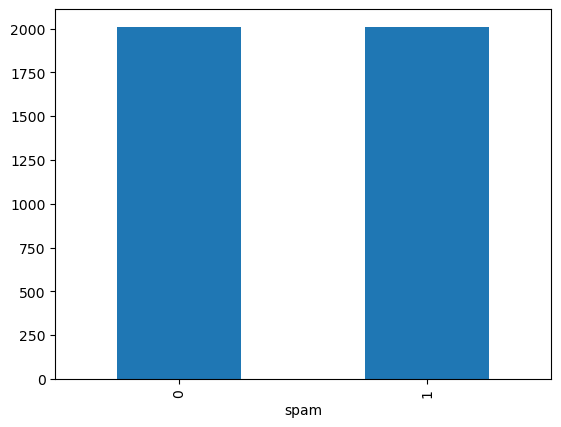

In [39]:
file_path1 = "D:\\ml\\xgboost-main\\data\\spambase\\smote_data.csv"
#generate new data by SMOTE
con = Counter(y_train)
print("Przed", con)
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
con1 = Counter(y_train_sm)
print("Po", con1)

#concat smote train X & y && save data
train_data_smote = pd.concat([X_train_sm, y_train_sm], axis=1)          #polaczenie danych wygenerowanych X_train oraz y_train
train_data_smote['generated_by_smote'] = ['original' if i < len(df_original) else 'smote' for i in range(len(train_data_smote))]
smote_data = train_data_smote[train_data_smote['generated_by_smote'] == 'smote'].drop('generated_by_smote', axis=1)
smote_data["source"]="smote"

if not os.path.exists(file_path1):
    smote_data.to_csv(file_path1, index=False)
else:
    print(f'Plik istnieje pod ścieżką: {file_path1}')

pd.Series(y_train_sm).value_counts().plot.bar()

### Oversampling - BorderLine SMOTE

Przed Counter({0: 2010, 1: 1358})
Po Counter({0: 2010, 1: 2010})


<Axes: xlabel='spam'>

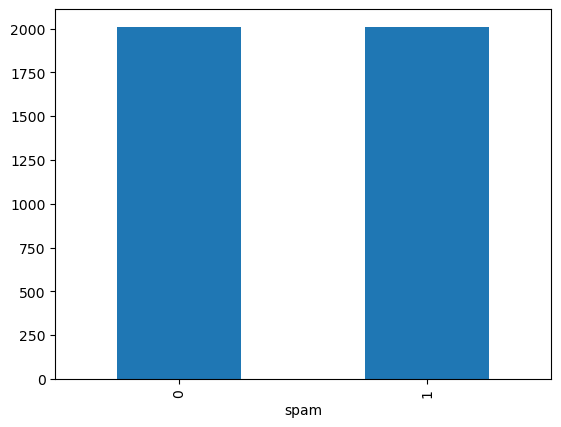

In [42]:
file_path2 = "D:\\ml\\xgboost-main\\data\\spambase\\boarderlinesmote_data.csv"
#generate new data by borderLineSMOTE
con3 = Counter(y_train)
print("Przed", con3)
brdsmote = BorderlineSMOTE(random_state=42)
X_train_bsm, y_train_bsm = brdsmote.fit_resample(X_train, y_train)
con4 = Counter(y_train_bsm)
print("Po", con4)

train_data_borderline_smote = pd.concat([X_train_bsm, y_train_bsm], axis=1)          #polaczenie danych wygenerowanych X_train oraz y_train
train_data_borderline_smote['generated_by_boarderline_smote'] = ['original' if i < len(df_original) else 'brd smote' for i in range(len(train_data_borderline_smote))]
boarderline_smote_data = train_data_borderline_smote[train_data_borderline_smote['generated_by_boarderline_smote'] == 'brd smote'].drop('generated_by_boarderline_smote', axis=1)
boarderline_smote_data["source"]="borderline smote"
if not os.path.exists(file_path2):
    boarderline_smote_data.to_csv(file_path2, index=False)
else:
    print(f'Plik istnieje pod ścieżką: {file_path2}')

pd.Series(y_train_bsm).value_counts().plot.bar()

### Oversampling - GAN

Dane wygenerowane:  spam
1    652
Name: count, dtype: int64
Before Counter({0: 2010, 1: 1358})
After Counter({0: 2010, 1: 2010})


<Axes: xlabel='spam'>

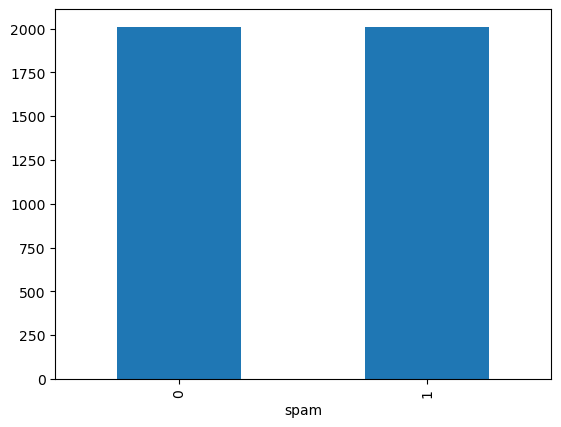

In [49]:
file_path3 = "D:\\ml\\xgboost-main\\data\\spambase\\GAN_data.csv"        #sciezka wraz z nazwa pod jaka wygenerowac plik
#generate new data by GAN
columns_list = df_original.columns
target_num = df_original['spam'].value_counts()
ctgan = CTGAN(epochs=10)        #model

if target_num[0] > target_num[1]:
    data_y1 = df_original[df_original['spam']==1]
    ctgan.fit(data_y1, columns_list)
    sample = abs(target_num[0]-target_num[1])
    df_GAN = ctgan.sample(sample)
    print('Dane wygenerowane: ', df_GAN['spam'].value_counts())
    balanced_data = pd.concat([df_original, df_GAN], ignore_index=False)
else:
    data_y0 = df_original[df_original['spam']==0]
    ctgan.fit(data_y0, columns_list)
    sample = abs(target_num[0]-target_num[1])
    df_GAN = ctgan.sample(sample)
    print('Dane wygenerowane: ', df_GAN['spam'].value_counts())
    balanced_data = pd.concat([df_original, df_GAN], ignore_index=False)
  
y_train_gan = balanced_data["spam"]
X_train_gan = df.drop(columns=["spam"])
con5 = Counter(y_train)
print("Before", con5)
con6 = Counter(y_train_gan)
print("After", con6)

df_GAN["source"]="gan"
if not os.path.exists(file_path3):
    df_GAN.to_csv(file_path3, index=False)
else:
    print(f'Plik istnieje pod ścieżką: {file_path3}')

pd.Series(y_train_gan).value_counts().plot.bar()

### Models + fit_data

In [50]:
models = {
    
    "LR": LogisticRegression(),             # logistic regression dla niezbalansowanych 
    "LR_SMOTE": LogisticRegression(),       # logistic regression dla zbalansowanych SMOTE
    "LR_BrdSMOTE": LogisticRegression(),    # logistic regression dla zbalansowanych BoarderrLineSMOTE
    "LR_GAN": LogisticRegression(),         # logistic regression dla zbalansowanych GAN
    
    "DT": DecisionTreeClassifier(),             # decision tree dla niezbalansowanych
    "DT_SMOTE": DecisionTreeClassifier(),       # decision tree dla zbalansowanych SMOTE
    "DT_BrdSMOTE": DecisionTreeClassifier(),     # decision tree dla zbalansowanych BoarderrLineSMOTE
    "DT_GAN": DecisionTreeClassifier(),          # decision tree dla zbalansowanych GAN
    
    "RF": RandomForestClassifier(),             # random forest dla niezbalansowanych
    "RF_SMOTE": RandomForestClassifier(),       # random forest dla zbalansowanych SMOTE
    "RF_BrdSMOTE": RandomForestClassifier(),    # random forest dla zbalansowanych BoarderrLineSMOTE
    "RF_GAN": RandomForestClassifier(),        # random forest dla zbalansowanych GAN
    
    "XGB": XGBClassifier(),           # xgboost dla niezbalansowanych
    "XGB_SMOTE": XGBClassifier(),     # xgboost dla zbalansowanych SMOTE
    "XGB_BrdSMOTE": XGBClassifier(),    # xgboost dla zbalansowanych BoarderrLineSMOTE
    "XGB_GAN": XGBClassifier(),       # xgboost dla zbalansowanych GAN
    
    "XGB_RF": XGBRFClassifier(),            # xgboost rf dla niezbalansowanych
    "XGB_RF_SMOTE": XGBRFClassifier(),         # xgboost rf dla zbalansowanych SMOTE
    "XGB_RF_BrdSMOTE": XGBRFClassifier(),   # xgboost rf dla zbalansowanych BoarderrLineSMOTE
    "XGB_RF_GAN": XGBRFClassifier()          # xgboost rf dla zbalansowanych GAN
}


fit_data = {
    
    "LR": (X_train, y_train),
    "LR_SMOTE": (X_train_sm, y_train_sm),
    "LR_BrdSMOTE": (X_train_bsm, y_train_bsm),
    "LR_GAN": (X_train_gan, y_train_gan),
    
    "DT": (X_train, y_train),
    "DT_SMOTE": (X_train_sm, y_train_sm),
    "DT_BrdSMOTE": (X_train_bsm, y_train_bsm),
    "DT_GAN": (X_train_gan, y_train_gan),
    
    "RF": (X_train, y_train),
    "RF_SMOTE": (X_train_sm, y_train_sm),
    "RF_BrdSMOTE": (X_train_bsm, y_train_bsm),
    "RF_GAN": (X_train_gan, y_train_gan),
    
    "XGB": (X_train, y_train),
    "XGB_SMOTE": (X_train_sm, y_train_sm),
    "XGB_BrdSMOTE": (X_train_bsm, y_train_bsm),
    "XGB_GAN": (X_train_gan, y_train_gan),

    "XGB_RF": (X_train, y_train),
    "XGB_RF_SMOTE": (X_train_sm, y_train_sm),
    "XGB_RF_BrdSMOTE": (X_train_bsm, y_train_bsm),
    "XGB_RF_GAN": (X_train_gan, y_train_gan)
}

### GridSearch

In [ ]:
# PARAMS to Search
params_LR = {                               # dla LR
    #'class_weight':['balanced', 'none'],   # wagi dla poszczegolnych klas
    'max_iter':[100,500,1000]  ,
    'random_state':[0,10,20,30,40]        # ustalona losowość dla powtarzalności
                # ilosc iteracji
}

params_DT = {                               # dla DT
    'max_depth':[4,8,12,16],                # maksymalna głębokość drzewa
    'random_state':[0,10,20,30,40],         # ustalona losowość dla powtarzalności
    'min_samples_leaf':[1,2]                # minimalna ilosc probek lisci
}

params_RF = {
    'n_estimators':[20,40,60,80,100],       # rozmiar lasu
    'max_depth':[4,8,12,16],                # maksymalna głębokość drzewa
    'min_samples_leaf':[1,2],               # minimalna ilosc probek lisci
    'random_state':[0,10,20,30,40],         # ustalona losowość dla powtarzalności
}

params_XGB = {                              # dla XGBoost
    'max_depth':[4,8,12,16],                # maksymalna głębokość drzewa
    'subsample':[0.5,0.6,0.7,0.8,0.9,1]
}

params_XGB_RF = {                           # dla XGBoost RF
    'max_depth':[4,8,12,16],                # maksymalna głębokość drzewa
    'n_estimators':[20,40,60,80,100],       # rozmiar lasu
    'subsample':[0.5,0.6,0.7,0.8,0.9,1],
    'random_state':[0,10,20,30,40]          # ustalona losowość dla powtarzalności
}

goal = ['precision', 'recall', 'f1', 'accuracy'] 
call = "GAN"
file_path = "D:\\ml\\xgboost-main\\reports\\spambase\\GAN.txt"

for score_1 in goal:
    
    model_LR = LogisticRegression()
    model_LR_SMOTE = LogisticRegression()
    model_LR_BrdSMOTE = LogisticRegression()
    model_LR_GAN = LogisticRegression()
    model_DT = DecisionTreeClassifier()
    model_DT_SMOTE = DecisionTreeClassifier()
    model_DT_BrdSMOTE = DecisionTreeClassifier()
    model_DT_GAN = DecisionTreeClassifier()
    model_RF = RandomForestClassifier()
    model_RF_SMOTE = RandomForestClassifier()
    model_RF_BrdSMOTE = RandomForestClassifier()
    model_RF_GAN = RandomForestClassifier()
    model_XGB = XGBClassifier()
    model_XGB_SMOTE = XGBClassifier()
    model_XGB_BrdSMOTE = XGBClassifier()
    model_XGB_GAN = XGBClassifier()
    model_XGB_RF = XGBRFClassifier()
    model_XGB_RF_SMOTE = XGBRFClassifier()
    model_XGB_RF_BrdSMOTE = XGBRFClassifier()
    model_XGB_RF_GAN = XGBRFClassifier()
    
    model_LR_GAN = GridSearchCV(model_LR_GAN,param_grid=params_LR,scoring=score_1).fit(X_train_gan,y_train_gan)
    model_DT_GAN = GridSearchCV(model_DT_GAN,param_grid=params_DT,scoring=score_1).fit(X_train_gan,y_train_gan)
    model_RF_GAN = GridSearchCV(model_RF_GAN,param_grid=params_RF,scoring=score_1).fit(X_train_gan,y_train_gan)
    model_XGB_GAN = GridSearchCV(model_XGB_GAN,param_grid=params_XGB, scoring=score_1).fit(X_train_gan,y_train_gan)
    model_XGB_RF_GAN = GridSearchCV(model_XGB_RF_GAN,param_grid=params_XGB_RF,scoring=score_1).fit(X_train_gan,y_train_gan)
    
    with open(file_path, "a+") as f:
        print(f'scoring: {score_1}', file=f)
        print(f'Best parameters for {score_1} & LR + {call}:', model_LR_GAN.best_params_, file=f)
        print(f'Best score for {score_1} & LR + {call}:', model_LR_GAN.best_score_, file=f)
        print(f'Best parameters for {score_1} & DT + {call}:', model_DT_GAN.best_params_, file=f)
        print(f'Best score for {score_1} & DT + {call}:', model_DT_GAN.best_score_, file=f)
        print(f'Best parameters for {score_1} & RF + {call}:', model_RF_GAN.best_params_, file=f)
        print(f'Best score for {score_1} & RF + {call}:', model_RF_GAN.best_score_, file=f)
        print(f'Best parameters for {score_1} & XGB + {call}:', model_XGB_GAN.best_params_, file=f)
        print(f'Best score for {score_1} & XGB + {call}:', model_XGB_GAN.best_score_, file=f)
        print(f'Best parameters for {score_1} & XGB RF + {call}:', model_XGB_RF_GAN.best_params_, file=f)
        print(f'Best score for {score_1} & XGB RF + {call}:', model_XGB_RF_GAN.best_score_, file=f)